## Introduction

### Description

This notebook demonstrates how to **detect and mask transient noise** in echosounder data using **echopype**.
Data courtesy of the [**British Antarctic Survey**](https://www.bas.ac.uk/), collected aboard the RRS James Clark Ross in the Scotia Sea by Sophie Fielding.
They were initially used to develop [**RapidKrill**](https://github.com/bas-acoustics/rapidkrill) and later incorporated into [**Echopy**](https://github.com/open-ocean-sounding/echopy).
They can be downloaded from: ftp://ftp.bas.ac.uk/rapidkrill/.

The workflow is inspired by approaches from [**Echopy**](https://github.com/open-ocean-sounding/echopy) and [**Matecho**](https://forge.ird.fr/lemar/active_acoustics/matecho).
We open raw **EK60** data (`.raw`), convert to an easily accessible format, add a depth coordinate, then compute transient-noise masks with built-in methods (e.g., **fielding**, **matecho**) and apply them to clean the echogram.

### Outline

1) [Open and convert raw echosounder data](#open-and-convert-raw-echosounder-data)  
2) [Apply transient noise filtering](#apply-transient-noise-filtering)  
3) [Show results on 38 kHz with profiles](#show-results-on-38-khz-with-profiles)

### Running the notebook

Use the conda environment in [`conda/environment-ep-main.yml`](../conda/environment-ep-main.yml).  
Example files are under `notebooks/example_data/transient_noise/`.  

### Note

We encourage importing Echopype as `ep` for consistency.

### Open and convert raw echosounder data

In [1]:
import echopype as ep

ed = ep.open_raw("./example_data/transient_noise/JR161-D20061118-T010645.raw", sonar_model="EK60", storage_options={"anon": True})
ed.to_zarr("./example_data/transient_noise/JR161-D20061118-T010645.zarr", overwrite="w")

c:\Users\lloyd\miniforge3\envs\echopype_examples\Lib\site-packages\echopype\convert\set_groups_ek60.py:149: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'channel' ('channel',) The recommendation is to set join explicitly for this case.
  ds = xr.merge(ds_env)
c:\Users\lloyd\miniforge3\envs\echopype_examples\Lib\site-packages\echopype\convert\set_groups_ek60.py:149: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merg

We open the converted EK60 file and compute Sv.

In [2]:
ed = ep.open_converted("./example_data/transient_noise/JR161-D20061118-T010645.zarr")
ds_Sv = ep.calibrate.compute_Sv(ed, waveform_mode="CW", encode_mode="power")
ds_Sv = ep.consolidate.add_depth(ds_Sv, depth_offset=5.76) # put 5.76 as an example, as we do not know the true value; it could be left at 0

We then inspect variable sizes and dimensions.

In [3]:
ds_Sv["channel"].values

array(['GPT  38 kHz 009072033fa5 1 ES38',
       'GPT 120 kHz 00907203422d 1 ES120-7',
       'GPT 200 kHz 009072033f91 1 ES200-7'], dtype='<U34')

In [4]:
ch = "GPT  38 kHz 009072033fa5 1 ES38"

da = ds_Sv["Sv"].sel(channel=ch, drop=True)          # Sv for one channel
depth = ds_Sv["depth"].sel(channel=ch, drop=True)    # depth for one channel

print("Sv dims:", da.dims)
print("Sv sizes:", da.sizes)
print("depth dims:", depth.dims)
print("depth sizes:", depth.sizes)

n_pings   = da.sizes["ping_time"]
n_ranges  = da.sizes["range_sample"]
print("Number of pings:", n_pings)
print("Number of samples per ping:", n_ranges)

if ("range_sample" in depth.dims) and (depth.ndim == 1):
    print("Depth vector length (1D):", depth.sizes["range_sample"])
elif depth.ndim == 2 and ("ping_time" in depth.dims) and ("range_sample" in depth.dims):
    print("Depth grid shape (2D):", {k: depth.sizes[k] for k in depth.dims})
    print("Depth along first ping:", depth.isel(ping_time=0).sizes["range_sample"])


Sv dims: ('ping_time', 'range_sample')
Sv sizes: Frozen({'ping_time': 403, 'range_sample': 5377})
depth dims: ('ping_time', 'range_sample')
depth sizes: Frozen({'ping_time': 403, 'range_sample': 5377})
Number of pings: 403
Number of samples per ping: 5377
Depth grid shape (2D): {'ping_time': 403, 'range_sample': 5377}
Depth along first ping: 5377


We plot the data.

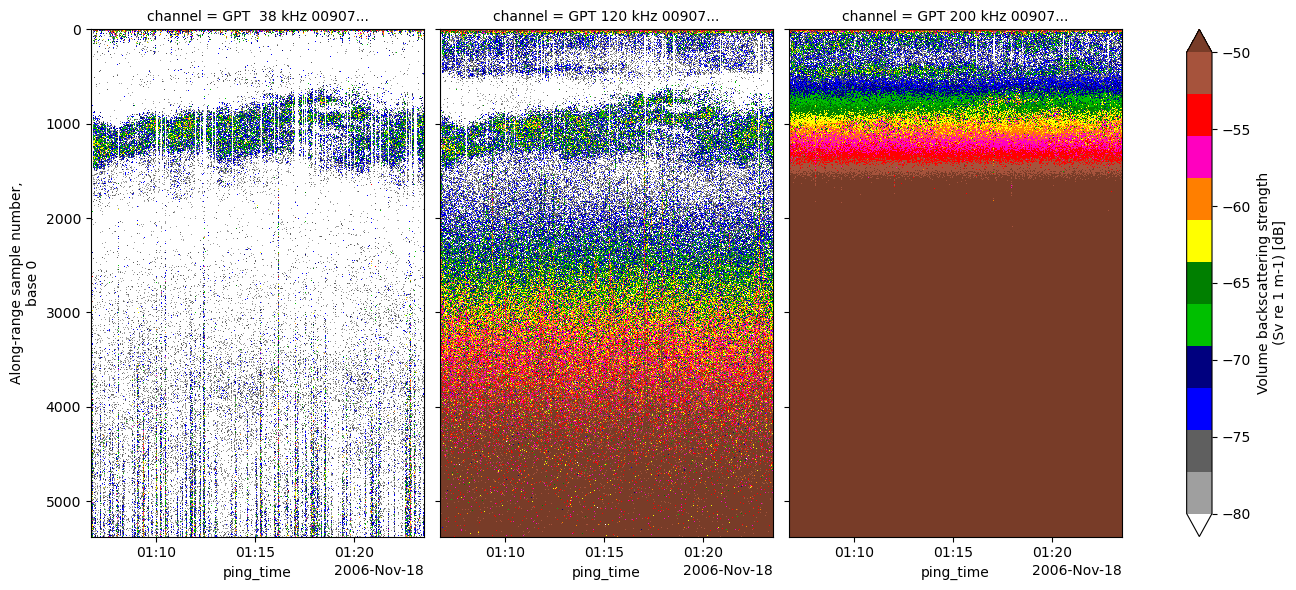

In [5]:
import matplotlib as mpl
import echopype.colormap

ds_Sv["Sv"].plot(
    x="ping_time",
    y="range_sample",
    row="channel", col_wrap=3,
    vmin=-80, vmax=-50,
    cmap=mpl.colormaps["ep.ek500"],
    yincrease=False,
    figsize=(14, 6),
)

Then we trim each channel to its maximum usable depth range.
This step removes parts of the echogram where the signal-to-noise ratio becomes too low for meaningful interpretation.
For example, on the 200 kHz channel, the acoustic signal is strongly attenuated with depth and reliable backscatter is typically limited to the upper ~100–120 m.
Trimming at around 110 m therefore helps avoid plotting noise-dominated data.
We make a deep copy of the dataset (`deep=True`) to ensure the original remains unchanged.

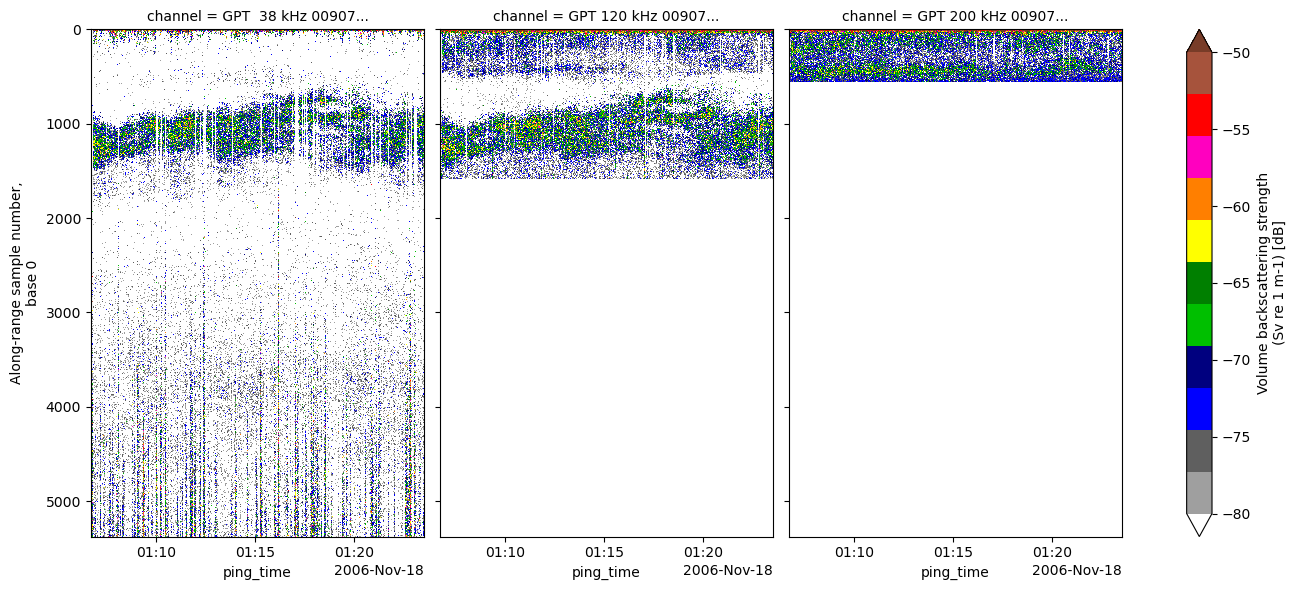

In [6]:
# Work on a completely independent copy (deep = True)
ds_Sv_trimmed = ds_Sv.copy(deep=True)

depth = ds_Sv_trimmed["depth"]   # dims: (channel, ping_time, range_sample)
Sv    = ds_Sv_trimmed["Sv"]

# Per-channel depth cutoffs (keep shallower than or equal to cutoff)
cutoffs = {
    "GPT 120 kHz 00907203422d 1 ES120-7": 300,  # keep <= 300 m
    "GPT 200 kHz 009072033f91 1 ES200-7": 110,  # keep <= 110 m
}

for ch_name, cutoff in cutoffs.items():
    if ch_name not in depth["channel"].values:
        print(f"[warn] channel not found: {ch_name}")
        continue
    # Per-channel depth mask (True = keep)
    keep_mask = (depth.sel(channel=ch_name) <= cutoff)
    # Apply to Sv for that channel (coords align by ping_time, range_sample)
    ds_Sv_trimmed["Sv"].loc[dict(channel=ch_name)] = (
        Sv.sel(channel=ch_name).where(keep_mask)
    )

# Plot result (per channel)
ds_Sv_trimmed["Sv"].plot(
    x="ping_time",
    y="range_sample",
    row="channel", col_wrap=3,
    vmin=-80, vmax=-50,
    cmap=mpl.colormaps["ep.ek500"],
    yincrease=False,
    figsize=(14, 6),
)

### Apply transient noise filtering

We next apply the `fielding` method from the mask_transient module. This function is adapted from the implementation originally written by Alejandro Ariza for the [**Echopy**](https://github.com/open-ocean-sounding/echopy) library (© 2020).

This approach uses a two-stage vertical test:
- It compares each ping’s median Sv within a window to the neighborhood median.
- If a transient is detected, masking propagates upward in steps until the difference drops below a threshold.

This results in depth-resolved masking, removing only the affected parts of the water column.

In [7]:
mask_fielding = ep.clean.detect_transient(
    ds=ds_Sv_trimmed,
    method="fielding",
    params={
        "var_name": "Sv",
        "range_var": "depth",
        "r0": 900,
        "r1": 1000,
        "n": 10,
        "thr": (3, 1),
        "roff": 20,
        "jumps": 5,
        "maxts": -35,
        "start": 0,
    },
)

We then plot the resulting boolean mask per channel (`True`: kept/valid, `False`: transient noise).

Text(0.5, 1.02, 'Transient noise mask per channel (boolean values: True=kept (1), False=removed (0))')

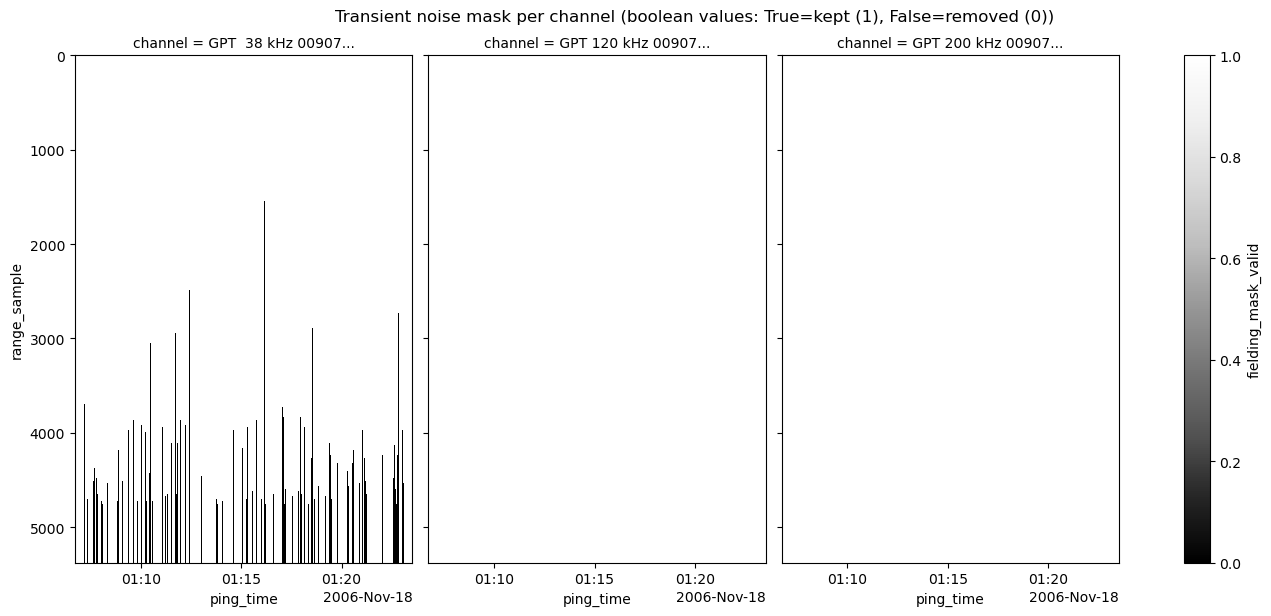

In [8]:
g = mask_fielding.plot.pcolormesh(
    x="ping_time",
    y="range_sample",
    col="channel",
    col_wrap=3,
    yincrease=False,
    cmap="Greys_r",  # use reversed for clarity
    figsize=(14, 6),
)

g.fig.suptitle(
    "Transient noise mask per channel (boolean values: True=kept (1), False=removed (0))",
    y=1.02
)

We then clean the echogram by applying the mask using `apply_mask()`, which replaces transient-noise values with NaNs.

In [9]:
ds_masked = ep.mask.apply_mask(
    ds_Sv_trimmed,
    mask_fielding,
    var_name="Sv",
    fill_value=float('nan')
)

We can now plot the masked data.

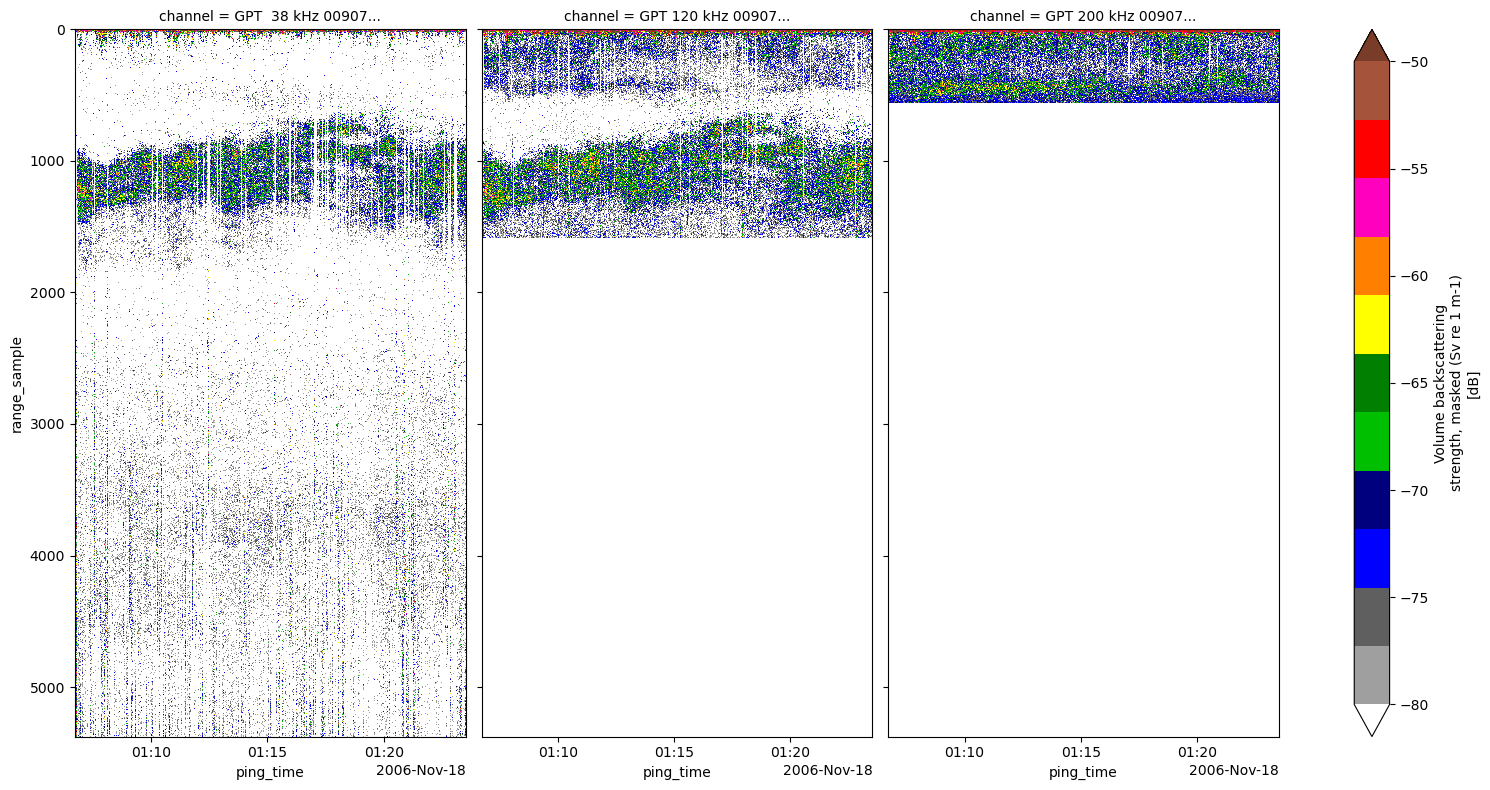

In [10]:
ds_masked["Sv"].plot(
    x="ping_time",
    row="channel", col_wrap=3,
    vmin=-80, vmax=-50,
    cmap=mpl.colormaps["ep.ek500"],
    yincrease=False,
    figsize=(16, 8)
)

Next, we compare the results with those obtained using the Matecho method (`method="matecho"`).
In this approach, the mean Sv of each ping (computed in linear units) is compared against a local percentile + ΔdB threshold (`delta_db`) across neighbouring pings.
Unlike Fielding, Matecho flags entire echogram columns: once a ping is marked as transient, the whole ping is masked.

In [11]:
mask_matecho = ep.clean.detect_transient(
    ds=ds_Sv_trimmed,
    method="matecho",
    params={
        "var_name": "Sv",
        "range_var": "depth",
        "bottom_var": None,
        "start_depth": 700,
        "window_meter": 300,
        "window_ping": 50,
        "percentile": 25,
        "delta_db": 8,
        "extend_ping": 0,
        "min_window": 5,
    },
)

We plot the corresponding boolean mask...

Text(0.5, 1.02, 'Transient noise mask per channel (0 = removed [False], 1 = kept [True])')

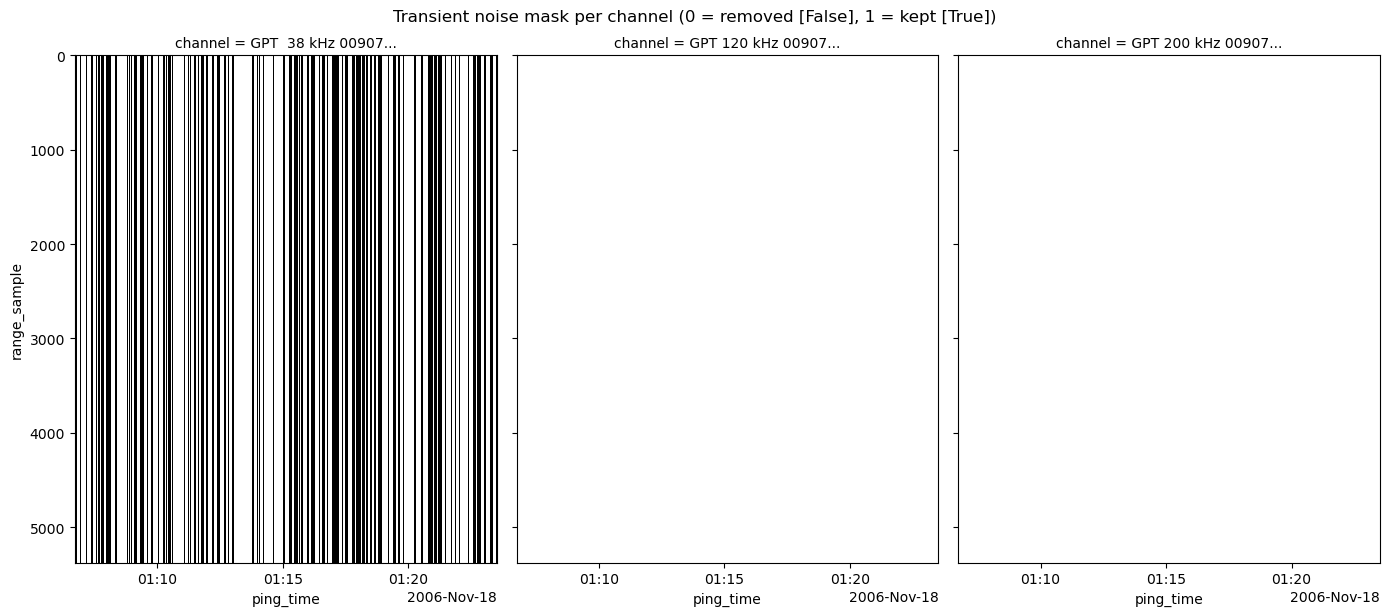

In [12]:
# Convert boolean mask to integers: False=0, True=1
mask_matecho_int = mask_matecho.astype(int)

g = mask_matecho_int.plot.pcolormesh(
    x="ping_time",
    y="range_sample",
    col="channel",
    col_wrap=3,
    yincrease=False,
    cmap="Greys_r",
    figsize=(14, 6),
    add_colorbar=False
)

g.fig.suptitle(
    "Transient noise mask per channel (0 = removed [False], 1 = kept [True])",
    y=1.02
)

...and apply it to obtain the cleaned dataset.

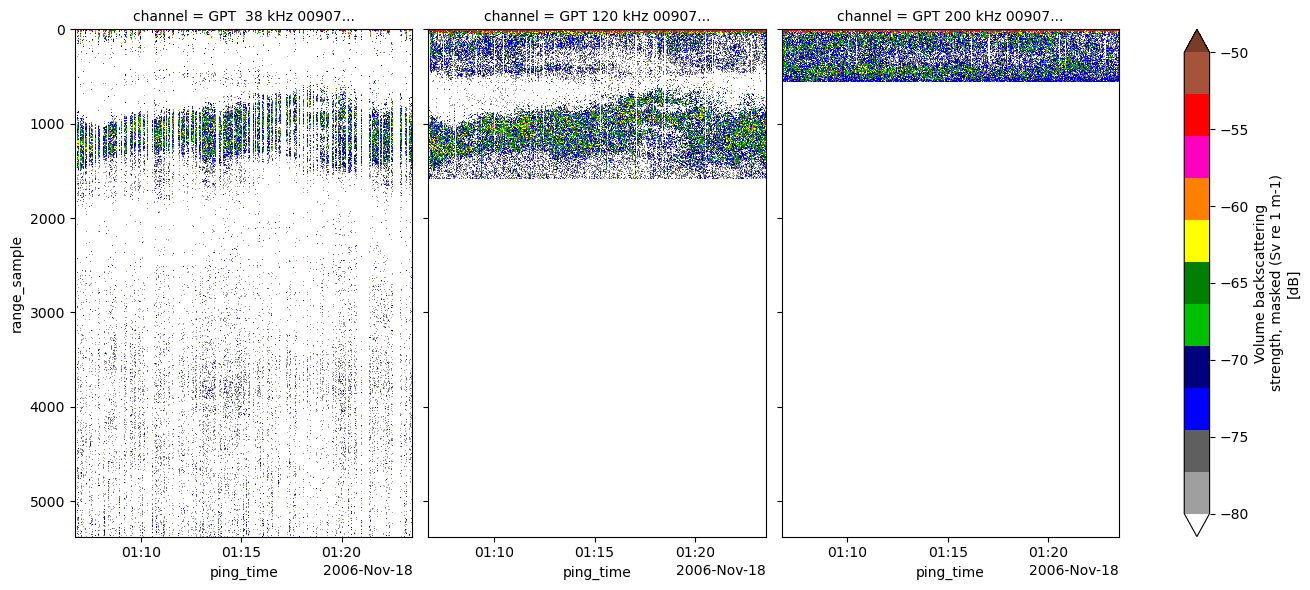

In [13]:
ds_masked = ep.mask.apply_mask(
    source_ds=ds_Sv_trimmed,
    mask=mask_matecho,
    var_name="Sv",
    fill_value=float("nan"),
)

ds_masked["Sv"].plot(
    x="ping_time",
    y="range_sample",
    col="channel",
    col_wrap=3,
    vmin=-80, vmax=-50,
    cmap=mpl.colormaps.get("ep.ek500", mpl.colormaps["viridis"]),
    yincrease=False,
    figsize=(14, 6),
)

### Show results on 38 kHz with profiles

Finally, we examine the outcome of the column-wise transient noise removal (`matecho`) on the 38 kHz channel.
The same analysis could be performed using the `fielding` approach to target short, deep bursts while limiting masking to the affected depths.

Here, some deep transient bursts appear to attenuate the signal throughout the water column; therefore, we choose to remove the entire ping.
To evaluate the processing, we display both raw and masked echograms together with their associated mean and median Sv profiles.
Using both provides complementary insight:

- The median is robust to occasional spikes.
- The mean highlights how energetic transients bias the original Sv distribution.

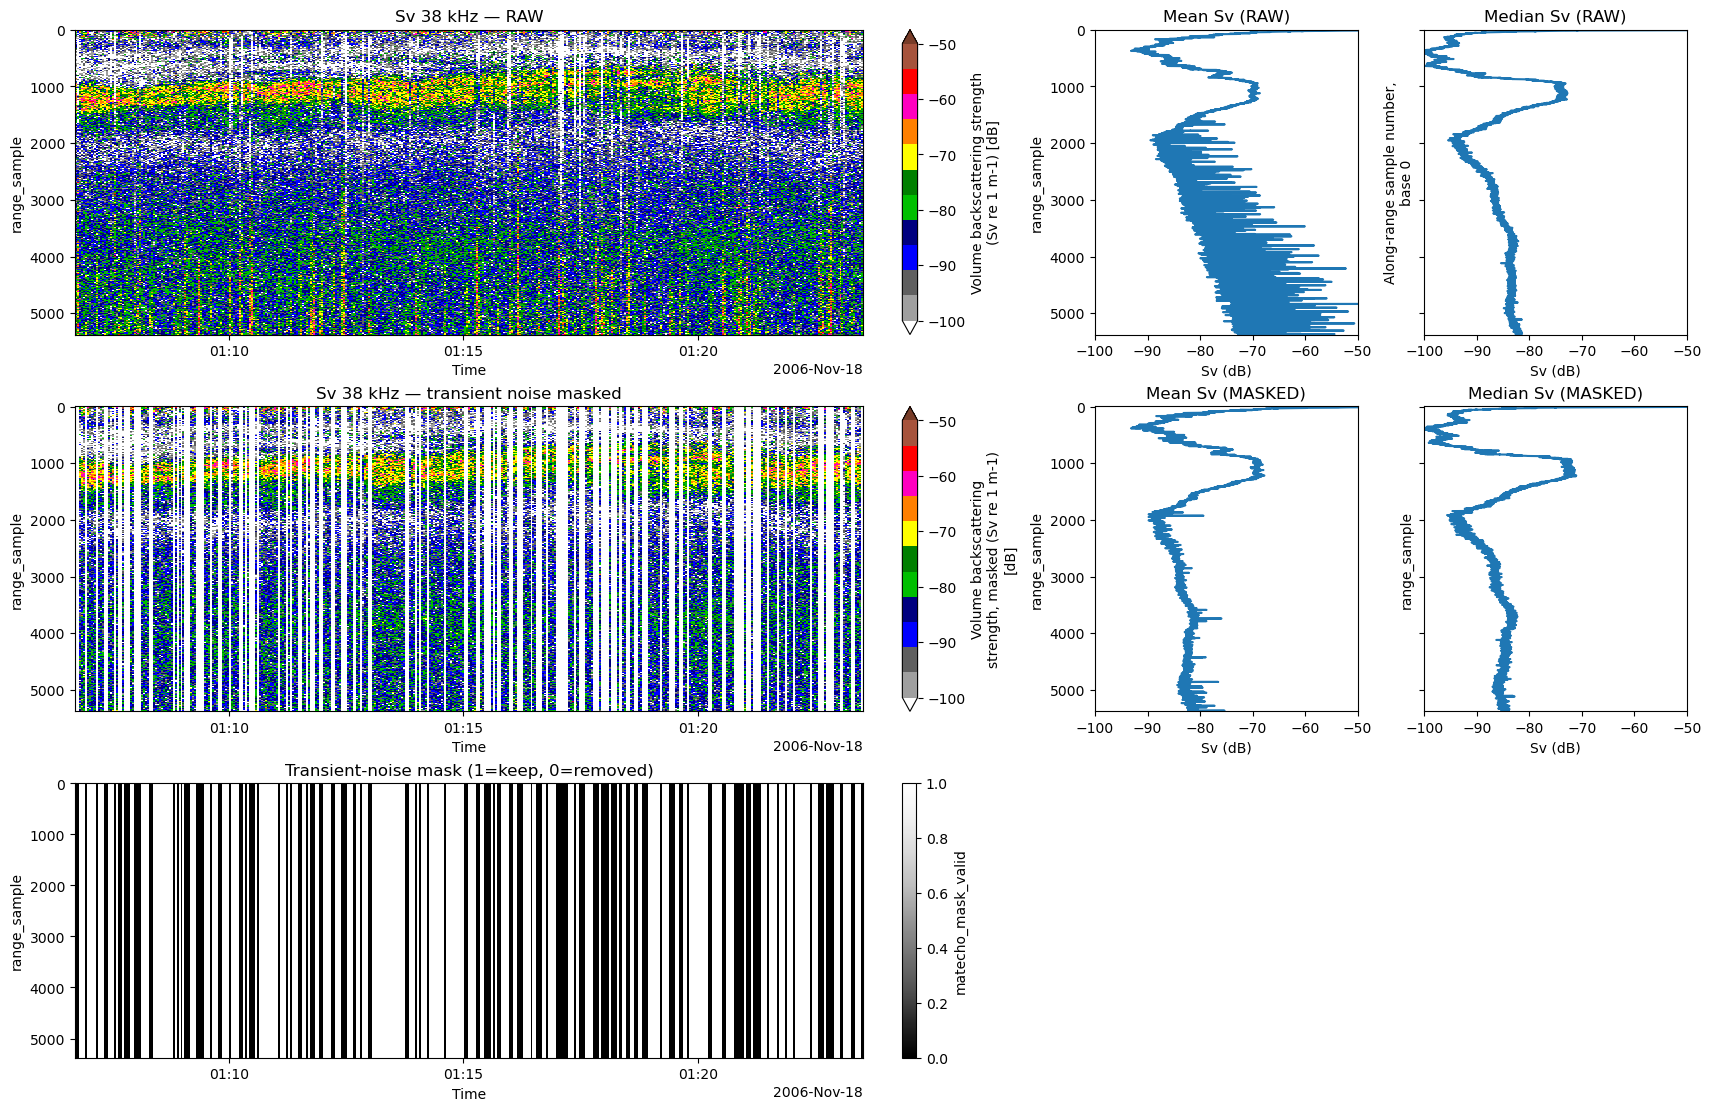

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import warnings
warnings.filterwarnings("ignore", message="All-NaN slice encountered", category=RuntimeWarning)

# pick your channel
ch38 = "GPT  38 kHz 009072033fa5 1 ES38"

def mean_db_over_time(ds, channel):
    da = ds["Sv"].sel(channel=channel)
    lin = 10.0 ** (da / 10.0)
    prof_lin = lin.mean("ping_time", skipna=True)
    return xr.apply_ufunc(np.log10, prof_lin, dask="parallelized") * 10.0

def median_db_over_time(ds, channel):
    da = ds["Sv"].sel(channel=channel)
    lin = 10.0 ** (da / 10.0)
    prof_lin = lin.quantile(0.5, dim="ping_time", skipna=True)
    return xr.apply_ufunc(np.log10, prof_lin, dask="parallelized") * 10.0

prof_raw_mean    = mean_db_over_time(ds_Sv_trimmed, ch38)
prof_raw_median  = median_db_over_time(ds_Sv_trimmed, ch38)
prof_mask_mean   = mean_db_over_time(ds_masked, ch38)
prof_mask_median = median_db_over_time(ds_masked, ch38)

# --- plotting ---
vmin, vmax = -100, -50
cmap_ek = "ep.ek500"

fig = plt.figure(figsize=(17, 11), constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=3,
                      width_ratios=[3.3, 1.1, 1.1],
                      height_ratios=[1.0, 1.0, 0.9])

# === Row 1: RAW ===
ax11 = fig.add_subplot(gs[0, 0])
ax12 = fig.add_subplot(gs[0, 1], sharey=ax11)
ax13 = fig.add_subplot(gs[0, 2], sharey=ax11)

ds_Sv_trimmed["Sv"].sel(channel=ch38).plot(
    x="ping_time", y="range_sample",
    yincrease=False, cmap=cmap_ek, vmin=vmin, vmax=vmax,
    add_colorbar=True, ax=ax11
)
ax11.set_title("Sv 38 kHz — RAW")
ax11.set_xlabel("Time")                 # show time ticks on first echogram
ax11.set_ylabel("range_sample")

prof_raw_mean.plot(y="range_sample", ax=ax12, lw=1.5)
ax12.set_title("Mean Sv (RAW)")
ax12.set_xlabel("Sv (dB)")
ax12.set_ylabel("range_sample")
ax12.invert_yaxis()

prof_raw_median.plot(y="range_sample", ax=ax13, lw=1.5)
ax13.set_title("Median Sv (RAW)")
ax13.set_xlabel("Sv (dB)")
ax13.tick_params(labelleft=False)
ax13.invert_yaxis()

# === Row 2: MASKED ===
ax21 = fig.add_subplot(gs[1, 0], sharex=ax11, sharey=ax11)
ax22 = fig.add_subplot(gs[1, 1], sharey=ax11)
ax23 = fig.add_subplot(gs[1, 2], sharey=ax11)

ds_masked["Sv"].sel(channel=ch38).plot(
    x="ping_time", y="range_sample",
    yincrease=False, cmap=cmap_ek, vmin=vmin, vmax=vmax,
    add_colorbar=True, ax=ax21
)
ax21.set_title("Sv 38 kHz — transient noise masked")
ax21.set_xlabel("Time")                 # and on the second echogram too
ax21.set_ylabel("range_sample")

prof_mask_mean.plot(y="range_sample", ax=ax22, lw=1.5)
ax22.set_title("Mean Sv (MASKED)")
ax22.set_xlabel("Sv (dB)")
ax22.set_ylabel("range_sample")
ax22.invert_yaxis()

prof_mask_median.plot(y="range_sample", ax=ax23, lw=1.5)
ax23.set_title("Median Sv (MASKED)")
ax23.set_xlabel("Sv (dB)")
ax23.tick_params(labelleft=False)
ax23.invert_yaxis()

# === Row 3: MASK ONLY ===
ax31 = fig.add_subplot(gs[2, 0], sharex=ax11, sharey=ax11)
ax32 = fig.add_subplot(gs[2, 1]); ax32.axis("off")
ax33 = fig.add_subplot(gs[2, 2]); ax33.axis("off")

mask_matecho.sel(channel=ch38).astype(int).plot(
    x="ping_time", y="range_sample",
    yincrease=False, cmap="Greys_r", add_colorbar=True, ax=ax31
)
ax31.set_title("Transient-noise mask (1=keep, 0=removed)")
ax31.set_xlabel("Time")
ax31.set_ylabel("range_sample")

# keep profile x-lims consistent with echogram color range
for axp in (ax12, ax13, ax22, ax23):
    axp.set_xlim(vmin, vmax)


In [15]:
from datetime import datetime, timezone

print(f"echopype: {ep.__version__}, xarray: {xr.__version__}")
print(f"\n{datetime.now(timezone.utc)}")

echopype: 0.10.2.dev27+ga2cfade, xarray: 2025.9.1

2025-10-06 10:13:46.808496+00:00
